In [1]:
!pip install scglue==0.3.2 anndata==0.8.0 scikit-misc faiss-gpu
!apt-get install bedtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [2]:
from itertools import chain
from random import Random

import anndata as ad
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [3]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [5]:
rna = ad.read_h5ad("rna-pp.h5ad")
atac = ad.read_h5ad("atac-pp.h5ad")
guidance = nx.read_graphml("guidance.graphml.gz")

In [6]:
rna.obs_names, atac.obs_names

(Index(['AAACAGCCAAAGCCTC-1', 'AAACAGCCAGAATGAC-1', 'AAACAGCCAGCTACGT-1',
        'AAACAGCCAGGCCTTG-1', 'AAACAGCCATAAGGAC-1', 'AAACAGCCATAATGTC-1',
        'AAACATGCAGCAATAA-1', 'AAACATGCAGCCAGAA-1', 'AAACATGCAGGCGATA-1',
        'AAACATGCAGTTTCTC-1',
        ...
        'TTTGTGGCATGAATCT-1', 'TTTGTGTTCAGTTCCC-1', 'TTTGTGTTCCCTCATA-1',
        'TTTGTGTTCCTTGAGG-1', 'TTTGTGTTCTAGCTAA-1', 'TTTGTTGGTACGCGCA-1',
        'TTTGTTGGTATTTGCC-1', 'TTTGTTGGTGATTACG-1', 'TTTGTTGGTTTCAGGA-1',
        'TTTGTTGGTTTCCACG-1'],
       dtype='object', length=12012),
 Index(['AAACAGCCAAAGCCTC-1', 'AAACAGCCAGAATGAC-1', 'AAACAGCCAGCTACGT-1',
        'AAACAGCCAGGCCTTG-1', 'AAACAGCCATAAGGAC-1', 'AAACAGCCATAATGTC-1',
        'AAACATGCAGCAATAA-1', 'AAACATGCAGCCAGAA-1', 'AAACATGCAGGCGATA-1',
        'AAACATGCAGTTTCTC-1',
        ...
        'TTTGTGGCATGAATCT-1', 'TTTGTGTTCAGTTCCC-1', 'TTTGTGTTCCCTCATA-1',
        'TTTGTGTTCCTTGAGG-1', 'TTTGTGTTCTAGCTAA-1', 'TTTGTTGGTACGCGCA-1',
        'TTTGTTGGTATTTGCC-1', 'TT

In [7]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_obs_names=True
)

In [8]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi",
    use_obs_names=True
)

In [9]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [14]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    model=scglue.models.PairedSCGLUEModel,
    fit_kws={
        "directory": "glue"
    }
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


INFO:fit_SCGLUE:Pretraining SCGLUE model...


[INFO] check_graph: Checking variable coverage...


INFO:check_graph:Checking variable coverage...


[INFO] check_graph: Checking edge attributes...


INFO:check_graph:Checking edge attributes...


[INFO] check_graph: Checking self-loops...


INFO:check_graph:Checking self-loops...


[INFO] check_graph: Checking graph symmetry...


INFO:check_graph:Checking graph symmetry...


[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 13031


INFO:PairedSCGLUEModel:Setting `graph_batch_size` = 13031


[INFO] PairedSCGLUEModel: Setting `max_epochs` = 285


INFO:PairedSCGLUEModel:Setting `max_epochs` = 285


[INFO] PairedSCGLUEModel: Setting `patience` = 24


INFO:PairedSCGLUEModel:Setting `patience` = 24


[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 12


INFO:PairedSCGLUEModel:Setting `reduce_lr_patience` = 12
DEBUG:GraphDataset:Started background process: 1893


[INFO] PairedSCGLUETrainer: Using training directory: "glue/pretrain"


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:PairedSCGLUETrainer:Using training directory: "glue/pretrain"


[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.51, 'g_kl': 0.011, 'g_elbo': 0.521, 'x_rna_nll': 0.352, 'x_rna_kl': 0.013, 'x_rna_elbo': 0.365, 'x_atac_nll': 0.198, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.2, 'dsc_loss': 0.691, 'vae_loss': 0.614, 'gen_loss': 0.579, 'joint_cross_loss': 0.548, 'real_cross_loss': 0.56, 'cos_loss': 0.3}, val={'g_nll': 0.504, 'g_kl': 0.012, 'g_elbo': 0.516, 'x_rna_nll': 0.35, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.361, 'x_atac_nll': 0.196, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.199, 'dsc_loss': 0.691, 'vae_loss': 0.609, 'gen_loss': 0.575, 'joint_cross_loss': 0.546, 'real_cross_loss': 0.559, 'cos_loss': 0.308}, 4.6s elapsed


INFO:PairedSCGLUETrainer:[Epoch 10] train={'g_nll': 0.51, 'g_kl': 0.011, 'g_elbo': 0.521, 'x_rna_nll': 0.352, 'x_rna_kl': 0.013, 'x_rna_elbo': 0.365, 'x_atac_nll': 0.198, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.2, 'dsc_loss': 0.691, 'vae_loss': 0.614, 'gen_loss': 0.579, 'joint_cross_loss': 0.548, 'real_cross_loss': 0.56, 'cos_loss': 0.3}, val={'g_nll': 0.504, 'g_kl': 0.012, 'g_elbo': 0.516, 'x_rna_nll': 0.35, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.361, 'x_atac_nll': 0.196, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.199, 'dsc_loss': 0.691, 'vae_loss': 0.609, 'gen_loss': 0.575, 'joint_cross_loss': 0.546, 'real_cross_loss': 0.559, 'cos_loss': 0.308}, 4.6s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 20] train={'g_nll': 0.472, 'g_kl': 0.013, 'g_elbo': 0.485, 'x_rna_nll': 0.344, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.355, 'x_atac_nll': 0.19, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.193, 'dsc_loss': 0.691, 'vae_loss': 0.596, 'gen_loss': 0.561, 'joint_cross_loss': 0.534, 'real_cross_loss': 0.545, 'cos_loss': 0.338}, val={'g_nll': 0.473, 'g_kl': 0.013, 'g_elbo': 0.486, 'x_rna_nll': 0.343, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.354, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.693, 'vae_loss': 0.592, 'gen_loss': 0.557, 'joint_cross_loss': 0.531, 'real_cross_loss': 0.542, 'cos_loss': 0.339}, 4.3s elapsed


INFO:PairedSCGLUETrainer:[Epoch 20] train={'g_nll': 0.472, 'g_kl': 0.013, 'g_elbo': 0.485, 'x_rna_nll': 0.344, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.355, 'x_atac_nll': 0.19, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.193, 'dsc_loss': 0.691, 'vae_loss': 0.596, 'gen_loss': 0.561, 'joint_cross_loss': 0.534, 'real_cross_loss': 0.545, 'cos_loss': 0.338}, val={'g_nll': 0.473, 'g_kl': 0.013, 'g_elbo': 0.486, 'x_rna_nll': 0.343, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.354, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.693, 'vae_loss': 0.592, 'gen_loss': 0.557, 'joint_cross_loss': 0.531, 'real_cross_loss': 0.542, 'cos_loss': 0.339}, 4.3s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 30] train={'g_nll': 0.461, 'g_kl': 0.012, 'g_elbo': 0.473, 'x_rna_nll': 0.342, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.353, 'x_atac_nll': 0.188, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.691, 'vae_loss': 0.591, 'gen_loss': 0.556, 'joint_cross_loss': 0.53, 'real_cross_loss': 0.541, 'cos_loss': 0.337}, val={'g_nll': 0.459, 'g_kl': 0.012, 'g_elbo': 0.471, 'x_rna_nll': 0.341, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.353, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.589, 'gen_loss': 0.554, 'joint_cross_loss': 0.529, 'real_cross_loss': 0.541, 'cos_loss': 0.341}, 5.2s elapsed


INFO:PairedSCGLUETrainer:[Epoch 30] train={'g_nll': 0.461, 'g_kl': 0.012, 'g_elbo': 0.473, 'x_rna_nll': 0.342, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.353, 'x_atac_nll': 0.188, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.691, 'vae_loss': 0.591, 'gen_loss': 0.556, 'joint_cross_loss': 0.53, 'real_cross_loss': 0.541, 'cos_loss': 0.337}, val={'g_nll': 0.459, 'g_kl': 0.012, 'g_elbo': 0.471, 'x_rna_nll': 0.341, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.353, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.589, 'gen_loss': 0.554, 'joint_cross_loss': 0.529, 'real_cross_loss': 0.541, 'cos_loss': 0.341}, 5.2s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 40] train={'g_nll': 0.454, 'g_kl': 0.012, 'g_elbo': 0.465, 'x_rna_nll': 0.34, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.352, 'x_atac_nll': 0.188, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.692, 'vae_loss': 0.589, 'gen_loss': 0.554, 'joint_cross_loss': 0.528, 'real_cross_loss': 0.539, 'cos_loss': 0.337}, val={'g_nll': 0.453, 'g_kl': 0.012, 'g_elbo': 0.464, 'x_rna_nll': 0.339, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.695, 'vae_loss': 0.586, 'gen_loss': 0.551, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.538, 'cos_loss': 0.334}, 4.3s elapsed


INFO:PairedSCGLUETrainer:[Epoch 40] train={'g_nll': 0.454, 'g_kl': 0.012, 'g_elbo': 0.465, 'x_rna_nll': 0.34, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.352, 'x_atac_nll': 0.188, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.692, 'vae_loss': 0.589, 'gen_loss': 0.554, 'joint_cross_loss': 0.528, 'real_cross_loss': 0.539, 'cos_loss': 0.337}, val={'g_nll': 0.453, 'g_kl': 0.012, 'g_elbo': 0.464, 'x_rna_nll': 0.339, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.695, 'vae_loss': 0.586, 'gen_loss': 0.551, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.538, 'cos_loss': 0.334}, 4.3s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 50] train={'g_nll': 0.448, 'g_kl': 0.011, 'g_elbo': 0.46, 'x_rna_nll': 0.34, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.352, 'x_atac_nll': 0.188, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.693, 'vae_loss': 0.588, 'gen_loss': 0.553, 'joint_cross_loss': 0.528, 'real_cross_loss': 0.539, 'cos_loss': 0.335}, val={'g_nll': 0.45, 'g_kl': 0.011, 'g_elbo': 0.461, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.691, 'vae_loss': 0.585, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.538, 'cos_loss': 0.336}, 4.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 50] train={'g_nll': 0.448, 'g_kl': 0.011, 'g_elbo': 0.46, 'x_rna_nll': 0.34, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.352, 'x_atac_nll': 0.188, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.693, 'vae_loss': 0.588, 'gen_loss': 0.553, 'joint_cross_loss': 0.528, 'real_cross_loss': 0.539, 'cos_loss': 0.335}, val={'g_nll': 0.45, 'g_kl': 0.011, 'g_elbo': 0.461, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.691, 'vae_loss': 0.585, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.538, 'cos_loss': 0.336}, 4.4s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 60] train={'g_nll': 0.444, 'g_kl': 0.011, 'g_elbo': 0.455, 'x_rna_nll': 0.339, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.692, 'vae_loss': 0.587, 'gen_loss': 0.552, 'joint_cross_loss': 0.527, 'real_cross_loss': 0.538, 'cos_loss': 0.334}, val={'g_nll': 0.445, 'g_kl': 0.011, 'g_elbo': 0.456, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.185, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.583, 'gen_loss': 0.549, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.537, 'cos_loss': 0.334}, 4.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 60] train={'g_nll': 0.444, 'g_kl': 0.011, 'g_elbo': 0.455, 'x_rna_nll': 0.339, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.692, 'vae_loss': 0.587, 'gen_loss': 0.552, 'joint_cross_loss': 0.527, 'real_cross_loss': 0.538, 'cos_loss': 0.334}, val={'g_nll': 0.445, 'g_kl': 0.011, 'g_elbo': 0.456, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.185, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.583, 'gen_loss': 0.549, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.537, 'cos_loss': 0.334}, 4.4s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 70] train={'g_nll': 0.443, 'g_kl': 0.011, 'g_elbo': 0.453, 'x_rna_nll': 0.339, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.692, 'vae_loss': 0.586, 'gen_loss': 0.551, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.537, 'cos_loss': 0.333}, val={'g_nll': 0.442, 'g_kl': 0.011, 'g_elbo': 0.453, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.585, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.539, 'cos_loss': 0.332}, 5.5s elapsed


INFO:PairedSCGLUETrainer:[Epoch 70] train={'g_nll': 0.443, 'g_kl': 0.011, 'g_elbo': 0.453, 'x_rna_nll': 0.339, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.19, 'dsc_loss': 0.692, 'vae_loss': 0.586, 'gen_loss': 0.551, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.537, 'cos_loss': 0.333}, val={'g_nll': 0.442, 'g_kl': 0.011, 'g_elbo': 0.453, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.585, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.539, 'cos_loss': 0.332}, 5.5s elapsed


[INFO] LRScheduler: Learning rate reduction: step 1


INFO:LRScheduler:Learning rate reduction: step 1


[INFO] PairedSCGLUETrainer: [Epoch 80] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.451, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.536, 'cos_loss': 0.33}, val={'g_nll': 0.441, 'g_kl': 0.011, 'g_elbo': 0.451, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.689, 'vae_loss': 0.582, 'gen_loss': 0.548, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.536, 'cos_loss': 0.327}, 4.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 80] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.451, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.536, 'cos_loss': 0.33}, val={'g_nll': 0.441, 'g_kl': 0.011, 'g_elbo': 0.451, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.689, 'vae_loss': 0.582, 'gen_loss': 0.548, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.536, 'cos_loss': 0.327}, 4.4s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 90] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.329}, val={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.583, 'gen_loss': 0.548, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.536, 'cos_loss': 0.332}, 4.6s elapsed


INFO:PairedSCGLUETrainer:[Epoch 90] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.329}, val={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.583, 'gen_loss': 0.548, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.536, 'cos_loss': 0.332}, 4.6s elapsed


[INFO] LRScheduler: Learning rate reduction: step 2


INFO:LRScheduler:Learning rate reduction: step 2


[INFO] PairedSCGLUETrainer: [Epoch 100] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.328}, val={'g_nll': 0.439, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.583, 'gen_loss': 0.548, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.537, 'cos_loss': 0.329}, 5.2s elapsed


INFO:PairedSCGLUETrainer:[Epoch 100] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.328}, val={'g_nll': 0.439, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.583, 'gen_loss': 0.548, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.537, 'cos_loss': 0.329}, 5.2s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 110] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.328}, val={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.583, 'gen_loss': 0.548, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.537, 'cos_loss': 0.328}, 4.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 110] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.328}, val={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.583, 'gen_loss': 0.548, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.537, 'cos_loss': 0.328}, 4.4s elapsed


[INFO] LRScheduler: Learning rate reduction: step 3


INFO:LRScheduler:Learning rate reduction: step 3


[INFO] PairedSCGLUETrainer: [Epoch 120] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.451, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.329}, val={'g_nll': 0.439, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.538, 'cos_loss': 0.332}, 4.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 120] train={'g_nll': 0.44, 'g_kl': 0.011, 'g_elbo': 0.451, 'x_rna_nll': 0.337, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.187, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.329}, val={'g_nll': 0.439, 'g_kl': 0.011, 'g_elbo': 0.45, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.538, 'cos_loss': 0.332}, 4.4s elapsed
2024-12-06 06:59:14,496 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "116"...


INFO:EarlyStopping:Restoring checkpoint "116"...


[INFO] EarlyStopping: Restoring checkpoint "116"...


/usr/local/lib/python3.10/dist-packages/scglue/models/plugins.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(directory / f"checkpoint_{ckpts[0]}.p

[INFO] fit_SCGLUE: Estimating balancing weight...


INFO:fit_SCGLUE:Estimating balancing weight...


[INFO] estimate_balancing_weight: Clustering cells...


INFO:estimate_balancing_weight:Clustering cells...
/usr/local/lib/python3.10/dist-packages/scglue/data.py:469: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_, resolution=resolution)


[INFO] estimate_balancing_weight: Matching clusters...


INFO:estimate_balancing_weight:Matching clusters...


[INFO] estimate_balancing_weight: Matching array shape = (22, 26)...


INFO:estimate_balancing_weight:Matching array shape = (22, 26)...


[INFO] estimate_balancing_weight: Estimating balancing weight...


INFO:estimate_balancing_weight:Estimating balancing weight...


[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...


INFO:fit_SCGLUE:Fine-tuning SCGLUE model...
DEBUG:PairedSCGLUEModel:Copied: g2v.vrepr
DEBUG:PairedSCGLUEModel:Copied: g2v.loc.weight
DEBUG:PairedSCGLUEModel:Copied: g2v.loc.bias
DEBUG:PairedSCGLUEModel:Copied: g2v.std_lin.weight
DEBUG:PairedSCGLUEModel:Copied: g2v.std_lin.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.linear_0.weight
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.linear_0.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.bn_0.weight
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.bn_0.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.linear_1.weight
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.linear_1.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.bn_1.weight
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.bn_1.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.loc.weight
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.loc.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.std_lin.weight
DEBUG:PairedSCGLUEModel:Copied: x2u.rna.std_lin.bias
DEBUG:PairedSCGLUEModel:Copied: x2u.atac.linear_0.weight
DEBUG:PairedSCGLUEModel:Copied: x

[INFO] check_graph: Checking variable coverage...


INFO:check_graph:Checking variable coverage...


[INFO] check_graph: Checking edge attributes...


INFO:check_graph:Checking edge attributes...


[INFO] check_graph: Checking self-loops...


INFO:check_graph:Checking self-loops...


[INFO] check_graph: Checking graph symmetry...


INFO:check_graph:Checking graph symmetry...


[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 13031


INFO:PairedSCGLUEModel:Setting `graph_batch_size` = 13031


[INFO] PairedSCGLUEModel: Setting `align_burnin` = 48


INFO:PairedSCGLUEModel:Setting `align_burnin` = 48


[INFO] PairedSCGLUEModel: Setting `max_epochs` = 285


INFO:PairedSCGLUEModel:Setting `max_epochs` = 285


[INFO] PairedSCGLUEModel: Setting `patience` = 24


INFO:PairedSCGLUEModel:Setting `patience` = 24


[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 12


INFO:PairedSCGLUEModel:Setting `reduce_lr_patience` = 12
DEBUG:GraphDataset:Started background process: 4806


[INFO] PairedSCGLUETrainer: Using training directory: "glue/fine-tune"


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:PairedSCGLUETrainer:Using training directory: "glue/fine-tune"


[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.438, 'g_kl': 0.01, 'g_elbo': 0.448, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.693, 'vae_loss': 0.585, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.537, 'cos_loss': 0.332}, val={'g_nll': 0.439, 'g_kl': 0.01, 'g_elbo': 0.449, 'x_rna_nll': 0.34, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.679, 'vae_loss': 0.594, 'gen_loss': 0.56, 'joint_cross_loss': 0.535, 'real_cross_loss': 0.547, 'cos_loss': 0.332}, 4.5s elapsed


INFO:PairedSCGLUETrainer:[Epoch 10] train={'g_nll': 0.438, 'g_kl': 0.01, 'g_elbo': 0.448, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.693, 'vae_loss': 0.585, 'gen_loss': 0.55, 'joint_cross_loss': 0.526, 'real_cross_loss': 0.537, 'cos_loss': 0.332}, val={'g_nll': 0.439, 'g_kl': 0.01, 'g_elbo': 0.449, 'x_rna_nll': 0.34, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.679, 'vae_loss': 0.594, 'gen_loss': 0.56, 'joint_cross_loss': 0.535, 'real_cross_loss': 0.547, 'cos_loss': 0.332}, 4.5s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 20] train={'g_nll': 0.437, 'g_kl': 0.01, 'g_elbo': 0.448, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.536, 'cos_loss': 0.333}, val={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.447, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.687, 'vae_loss': 0.592, 'gen_loss': 0.558, 'joint_cross_loss': 0.533, 'real_cross_loss': 0.545, 'cos_loss': 0.335}, 4.5s elapsed


INFO:PairedSCGLUETrainer:[Epoch 20] train={'g_nll': 0.437, 'g_kl': 0.01, 'g_elbo': 0.448, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.692, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.536, 'cos_loss': 0.333}, val={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.447, 'x_rna_nll': 0.339, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.687, 'vae_loss': 0.592, 'gen_loss': 0.558, 'joint_cross_loss': 0.533, 'real_cross_loss': 0.545, 'cos_loss': 0.335}, 4.5s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 30] train={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.447, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.693, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.535, 'cos_loss': 0.334}, val={'g_nll': 0.437, 'g_kl': 0.01, 'g_elbo': 0.447, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.192, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.194, 'dsc_loss': 0.684, 'vae_loss': 0.589, 'gen_loss': 0.555, 'joint_cross_loss': 0.531, 'real_cross_loss': 0.542, 'cos_loss': 0.333}, 5.0s elapsed


INFO:PairedSCGLUETrainer:[Epoch 30] train={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.447, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.693, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.535, 'cos_loss': 0.334}, val={'g_nll': 0.437, 'g_kl': 0.01, 'g_elbo': 0.447, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.192, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.194, 'dsc_loss': 0.684, 'vae_loss': 0.589, 'gen_loss': 0.555, 'joint_cross_loss': 0.531, 'real_cross_loss': 0.542, 'cos_loss': 0.333}, 5.0s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 40] train={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.446, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.535, 'cos_loss': 0.336}, val={'g_nll': 0.437, 'g_kl': 0.01, 'g_elbo': 0.448, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.347, 'x_atac_nll': 0.192, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.194, 'dsc_loss': 0.68, 'vae_loss': 0.588, 'gen_loss': 0.554, 'joint_cross_loss': 0.529, 'real_cross_loss': 0.541, 'cos_loss': 0.33}, 5.9s elapsed


INFO:PairedSCGLUETrainer:[Epoch 40] train={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.446, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.35, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.691, 'vae_loss': 0.584, 'gen_loss': 0.55, 'joint_cross_loss': 0.525, 'real_cross_loss': 0.535, 'cos_loss': 0.336}, val={'g_nll': 0.437, 'g_kl': 0.01, 'g_elbo': 0.448, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.347, 'x_atac_nll': 0.192, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.194, 'dsc_loss': 0.68, 'vae_loss': 0.588, 'gen_loss': 0.554, 'joint_cross_loss': 0.529, 'real_cross_loss': 0.541, 'cos_loss': 0.33}, 5.9s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 50] train={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.446, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.338}, val={'g_nll': 0.435, 'g_kl': 0.01, 'g_elbo': 0.445, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.193, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.684, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.545, 'cos_loss': 0.334}, 4.6s elapsed


INFO:PairedSCGLUETrainer:[Epoch 50] train={'g_nll': 0.436, 'g_kl': 0.01, 'g_elbo': 0.446, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.69, 'vae_loss': 0.584, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.338}, val={'g_nll': 0.435, 'g_kl': 0.01, 'g_elbo': 0.445, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.193, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.684, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.545, 'cos_loss': 0.334}, 4.6s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 60] train={'g_nll': 0.435, 'g_kl': 0.01, 'g_elbo': 0.445, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.689, 'vae_loss': 0.583, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.337}, val={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.34, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.197, 'dsc_loss': 0.683, 'vae_loss': 0.593, 'gen_loss': 0.559, 'joint_cross_loss': 0.535, 'real_cross_loss': 0.547, 'cos_loss': 0.333}, 4.5s elapsed


INFO:PairedSCGLUETrainer:[Epoch 60] train={'g_nll': 0.435, 'g_kl': 0.01, 'g_elbo': 0.445, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.189, 'dsc_loss': 0.689, 'vae_loss': 0.583, 'gen_loss': 0.549, 'joint_cross_loss': 0.524, 'real_cross_loss': 0.535, 'cos_loss': 0.337}, val={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.34, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.351, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.197, 'dsc_loss': 0.683, 'vae_loss': 0.593, 'gen_loss': 0.559, 'joint_cross_loss': 0.535, 'real_cross_loss': 0.547, 'cos_loss': 0.333}, 4.5s elapsed


[INFO] LRScheduler: Learning rate reduction: step 1


INFO:LRScheduler:Learning rate reduction: step 1


[INFO] PairedSCGLUETrainer: [Epoch 70] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.693, 'vae_loss': 0.582, 'gen_loss': 0.547, 'joint_cross_loss': 0.523, 'real_cross_loss': 0.533, 'cos_loss': 0.335}, val={'g_nll': 0.433, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.193, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.678, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.544, 'cos_loss': 0.336}, 5.2s elapsed


INFO:PairedSCGLUETrainer:[Epoch 70] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.693, 'vae_loss': 0.582, 'gen_loss': 0.547, 'joint_cross_loss': 0.523, 'real_cross_loss': 0.533, 'cos_loss': 0.335}, val={'g_nll': 0.433, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.193, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.678, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.544, 'cos_loss': 0.336}, 5.2s elapsed


[INFO] LRScheduler: Learning rate reduction: step 2


INFO:LRScheduler:Learning rate reduction: step 2


[INFO] PairedSCGLUETrainer: [Epoch 80] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.581, 'gen_loss': 0.547, 'joint_cross_loss': 0.522, 'real_cross_loss': 0.533, 'cos_loss': 0.334}, val={'g_nll': 0.432, 'g_kl': 0.01, 'g_elbo': 0.442, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.679, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.544, 'cos_loss': 0.337}, 5.3s elapsed


INFO:PairedSCGLUETrainer:[Epoch 80] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.581, 'gen_loss': 0.547, 'joint_cross_loss': 0.522, 'real_cross_loss': 0.533, 'cos_loss': 0.334}, val={'g_nll': 0.432, 'g_kl': 0.01, 'g_elbo': 0.442, 'x_rna_nll': 0.337, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.679, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.544, 'cos_loss': 0.337}, 5.3s elapsed


[INFO] PairedSCGLUETrainer: [Epoch 90] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.582, 'gen_loss': 0.547, 'joint_cross_loss': 0.523, 'real_cross_loss': 0.533, 'cos_loss': 0.334}, val={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.347, 'x_atac_nll': 0.192, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.68, 'vae_loss': 0.587, 'gen_loss': 0.553, 'joint_cross_loss': 0.529, 'real_cross_loss': 0.541, 'cos_loss': 0.335}, 4.5s elapsed


INFO:PairedSCGLUETrainer:[Epoch 90] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.582, 'gen_loss': 0.547, 'joint_cross_loss': 0.523, 'real_cross_loss': 0.533, 'cos_loss': 0.334}, val={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.347, 'x_atac_nll': 0.192, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.68, 'vae_loss': 0.587, 'gen_loss': 0.553, 'joint_cross_loss': 0.529, 'real_cross_loss': 0.541, 'cos_loss': 0.335}, 4.5s elapsed


[INFO] LRScheduler: Learning rate reduction: step 3


INFO:LRScheduler:Learning rate reduction: step 3


[INFO] PairedSCGLUETrainer: [Epoch 100] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.347, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.693, 'vae_loss': 0.581, 'gen_loss': 0.547, 'joint_cross_loss': 0.522, 'real_cross_loss': 0.533, 'cos_loss': 0.334}, val={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.684, 'vae_loss': 0.591, 'gen_loss': 0.557, 'joint_cross_loss': 0.533, 'real_cross_loss': 0.545, 'cos_loss': 0.335}, 4.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 100] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.347, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.693, 'vae_loss': 0.581, 'gen_loss': 0.547, 'joint_cross_loss': 0.522, 'real_cross_loss': 0.533, 'cos_loss': 0.334}, val={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.194, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.196, 'dsc_loss': 0.684, 'vae_loss': 0.591, 'gen_loss': 0.557, 'joint_cross_loss': 0.533, 'real_cross_loss': 0.545, 'cos_loss': 0.335}, 4.4s elapsed


[INFO] LRScheduler: Learning rate reduction: step 4


INFO:LRScheduler:Learning rate reduction: step 4


[INFO] PairedSCGLUETrainer: [Epoch 110] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.582, 'gen_loss': 0.547, 'joint_cross_loss': 0.523, 'real_cross_loss': 0.533, 'cos_loss': 0.335}, val={'g_nll': 0.433, 'g_kl': 0.01, 'g_elbo': 0.443, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.193, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.682, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.544, 'cos_loss': 0.334}, 5.4s elapsed


INFO:PairedSCGLUETrainer:[Epoch 110] train={'g_nll': 0.434, 'g_kl': 0.01, 'g_elbo': 0.444, 'x_rna_nll': 0.336, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.348, 'x_atac_nll': 0.186, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.188, 'dsc_loss': 0.692, 'vae_loss': 0.582, 'gen_loss': 0.547, 'joint_cross_loss': 0.523, 'real_cross_loss': 0.533, 'cos_loss': 0.335}, val={'g_nll': 0.433, 'g_kl': 0.01, 'g_elbo': 0.443, 'x_rna_nll': 0.338, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.349, 'x_atac_nll': 0.193, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.195, 'dsc_loss': 0.682, 'vae_loss': 0.59, 'gen_loss': 0.556, 'joint_cross_loss': 0.532, 'real_cross_loss': 0.544, 'cos_loss': 0.334}, 5.4s elapsed
2024-12-06 07:10:18,572 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "90"...


INFO:EarlyStopping:Restoring checkpoint "90"...


[INFO] EarlyStopping: Restoring checkpoint "90"...


/usr/local/lib/python3.10/dist-packages/scglue/models/plugins.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(directory / f"checkpoint_{ckpts[0]}.p

In [15]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "counts" for modality "rna"


INFO:integration_consistency:Using layer "counts" for modality "rna"


[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"


INFO:integration_consistency:Selecting aggregation "sum" for modality "rna"


[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"


INFO:integration_consistency:Selecting aggregation "sum" for modality "atac"


[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"


INFO:integration_consistency:Selecting log-norm preprocessing for modality "rna"


[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"


INFO:integration_consistency:Selecting log-norm preprocessing for modality "atac"


[INFO] get_metacells: Clustering metacells...


INFO:get_metacells:Clustering metacells...


[INFO] get_metacells: Aggregating metacells...


INFO:get_metacells:Aggregating metacells...


[INFO] metacell_corr: Computing correlation on 10 common metacells...


INFO:metacell_corr:Computing correlation on 10 common metacells...


[INFO] get_metacells: Clustering metacells...


INFO:get_metacells:Clustering metacells...


[INFO] get_metacells: Aggregating metacells...


INFO:get_metacells:Aggregating metacells...


[INFO] metacell_corr: Computing correlation on 20 common metacells...


INFO:metacell_corr:Computing correlation on 20 common metacells...


[INFO] get_metacells: Clustering metacells...


INFO:get_metacells:Clustering metacells...


[INFO] get_metacells: Aggregating metacells...


INFO:get_metacells:Aggregating metacells...


[INFO] metacell_corr: Computing correlation on 50 common metacells...


INFO:metacell_corr:Computing correlation on 50 common metacells...


[INFO] get_metacells: Clustering metacells...


INFO:get_metacells:Clustering metacells...


[INFO] get_metacells: Aggregating metacells...


INFO:get_metacells:Aggregating metacells...


[INFO] metacell_corr: Computing correlation on 100 common metacells...


INFO:metacell_corr:Computing correlation on 100 common metacells...


[INFO] get_metacells: Clustering metacells...


INFO:get_metacells:Clustering metacells...


[INFO] get_metacells: Aggregating metacells...


INFO:get_metacells:Aggregating metacells...


[INFO] metacell_corr: Computing correlation on 200 common metacells...


INFO:metacell_corr:Computing correlation on 200 common metacells...


,n_meta,consistency
0,10,0.413693
1,20,0.367186
2,50,0.347418
3,100,0.319806
4,200,0.287663


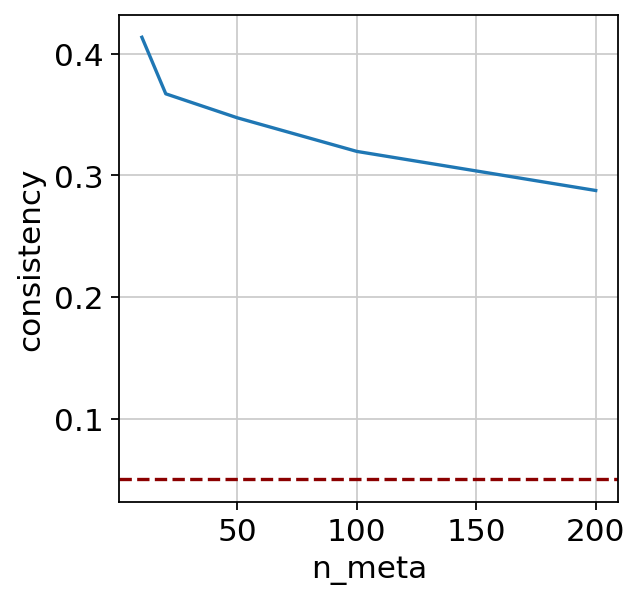

In [16]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")